In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
from constants import *
import os
from sklearn.ensemble import RandomTreesEmbedding, RandomForestRegressor
from utils import eval_stat
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from eda_utils import *
import matplotlib.pyplot as plt
import dateutil.parser
import impyute
import time
import random

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dir_list = os.listdir(root_data)
dir_list

['East_Champaran_data',
 'Gopalganj_data',
 'Sheohar_data',
 'Sitamarhi_data',
 'Vaishali_data',
 'West_Champaran_data']

In [4]:
class InvalidImputerException(Exception):
    "Imputer type can only be KNN, Mean or Iterative"
    pass

In [5]:
def read(filename):
    xls = pd.ExcelFile(filename)
    df_pm25 = pd.read_excel(xls, xls.sheet_names[0])
    df_latlong = pd.read_excel(xls, xls.sheet_names[1])
    return df_pm25, df_latlong

In [6]:
def create_dataframe(region_name, df_pm25, df_latlong):
    lat_long_dict = {}

    for col in df_latlong.columns[1:]:
        lat_long_dict[col] = [df_latlong[col][0], df_latlong[col][1]]
    
    data = []
    
    for i in range(len(df_pm25)):
        timestamp = df_pm25.loc[i, 'dt_time']
        for j in range(1, len(df_pm25.columns), 3):
            point = {}
            point['Timestamp'], point['Region'] = timestamp, region_name
            if df_pm25.columns[j] not in lat_long_dict:
                continue
            lat_long = lat_long_dict[df_pm25.columns[j]]
            point['Latitude'], point['Longitude'] = lat_long[0], lat_long[1]
            point['Meteo'] = [df_pm25.loc[i, df_pm25.columns[j+1]], df_pm25.loc[i, df_pm25.columns[j+2]],\
                            lat_long[0], lat_long[1]]
            point['PM25'] = df_pm25.loc[i, df_pm25.columns[j]]
            data.append(point)
    
    return data

In [7]:
data = []

for dir in dir_list:
    if dir == 'Sheohar_data' or dir == 'Sitamarhi_data' or dir == 'Vaishali_data':
        continue
    print(dir)
    for filename in os.listdir(os.path.join(root_data, dir)):
        root_path = os.path.join(root_data, dir)
        if ('sensor_data' in filename):
            df_pm25, df_latlong = read(os.path.join(root_path, filename))
            data.extend(create_dataframe(dir, df_pm25, df_latlong))

East_Champaran_data


Gopalganj_data
West_Champaran_data


In [8]:
cols = {'Timestamp': np.datetime64}

In [9]:
df = pd.DataFrame(data)
df = df.astype(cols)

In [10]:
df

,Timestamp,Region,Latitude,Longitude,Meteo,PM25
0,2023-05-05 14:00:00,East_Champaran_data,26.672,85.157,"[nan, nan, 26.672, 85.157]",NaN
1,2023-05-05 14:00:00,East_Champaran_data,26.837,85.067,"[nan, nan, 26.837, 85.067]",NaN
2,2023-05-05 14:00:00,East_Champaran_data,26.558,85.083,"[nan, nan, 26.558, 85.083]",NaN
3,2023-05-05 14:00:00,East_Champaran_data,26.530,85.196,"[nan, nan, 26.53, 85.196]",NaN
4,2023-05-05 14:00:00,East_Champaran_data,26.552,84.933,"[nan, nan, 26.552, 84.933]",NaN
...,...,...,...,...,...,...
62259,2023-06-21 12:00:00,West_Champaran_data,26.994,84.410,"[38.2, 48.6, 26.994, 84.41]",31.0
62260,2023-06-21 12:00:00,West_Champaran_data,27.133,84.060,"[35.0, 59.5, 27.133, 84.06]",26.0
62261,2023-06-21 12:00:00,West_Champaran_data,27.060,84.023,"[35.6, 54.8, 27.06, 84.023]",17.0
62262,2023-06-21 12:00:00,West_Champaran_data,26.907,84.136,"[36.2, 50.5, 26.907, 84.136]",15.0


In [11]:
for _, data in df.iterrows():
    assert data['Latitude'] == data['Meteo'][-2], "Latitude doesn't match"
    assert data['Longitude'] == data['Meteo'][-1], "Longitude doesn't match"

In [12]:
df.isna().sum()

Timestamp        0
Region           0
Latitude         0
Longitude        0
Meteo            0
PM25         12383
dtype: int64

In [13]:
df.groupby(['Region']).count()

,Timestamp,Latitude,Longitude,Meteo,PM25
Region,,,,,
East_Champaran_data,27072,27072,27072,27072,20133
Gopalganj_data,20538,20538,20538,20538,16471
West_Champaran_data,14654,14654,14654,14654,13277


In [14]:
df.dtypes

Timestamp    datetime64[ns]
Region               object
Latitude            float64
Longitude           float64
Meteo                object
PM25                float64
dtype: object

## Comparison between RT-RF model and XGBoost Model

In [42]:
stat_df_rt_rf = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', lat_long_split=True))
stat_df_xgboost = pd.DataFrame(region_wise_stat(df.copy(deep=True), lat_long_split=True))

In [43]:
stat_df_rt_rf

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,23.120182,0.859586,33.809355,0.633542
1,Gopalganj_data,22.684452,0.895907,39.813495,0.746592
2,West_Champaran_data,25.154412,0.849840,33.814865,0.612431


In [44]:
stat_df_xgboost

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,13.078169,0.933468,27.072721,0.775338
1,Gopalganj_data,11.383669,0.959065,26.479735,0.887075
2,West_Champaran_data,12.721604,0.936528,24.526777,0.777185


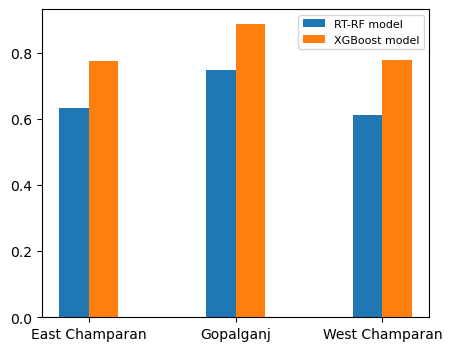

In [65]:
X_rt_rf, y_rt_rf, X_xgboost, y_xgboost = [], [], [], []


for i, data in stat_df_rt_rf.iterrows():
    X_rt_rf.append(i+1-0.1)
    y_rt_rf.append(data['Test_Pearson_R'])

for i, data in stat_df_xgboost.iterrows():
    X_xgboost.append(i+1+0.1)
    y_xgboost.append(data['Test_Pearson_R'])

width=0.2
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_rt_rf, y_rt_rf, width, label='RT-RF model')
plt.bar(X_xgboost, y_xgboost, width, label='XGBoost model')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(fontsize=8)

## Comparison between different data imputation techniques

### XGBoost

In [67]:
methods = ['knn', 'mean', 'iterative']

for method in methods:
    if method == 'knn':
        stat_df_knn = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, lat_long_split=True))
    elif method == 'mean':
        stat_df_mean = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, lat_long_split=True))
    elif method == 'iterative':
        stat_df_iterative = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, lat_long_split=True))

In [68]:
stat_df_knn

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,12.014002,0.939230,30.867961,0.809443
1,Gopalganj_data,11.827940,0.956911,26.271783,0.906151
2,West_Champaran_data,12.003580,0.937163,32.346647,0.758429


In [69]:
stat_df_mean

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,13.240685,0.930292,28.480441,0.773152
1,Gopalganj_data,11.379963,0.962695,28.892330,0.864337
2,West_Champaran_data,12.327409,0.932660,29.540799,0.749644


In [70]:
stat_df_iterative

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,10.457557,0.946416,41.749779,0.760406
1,Gopalganj_data,11.274815,0.963795,29.437184,0.880264
2,West_Champaran_data,12.742075,0.939104,25.596790,0.751965


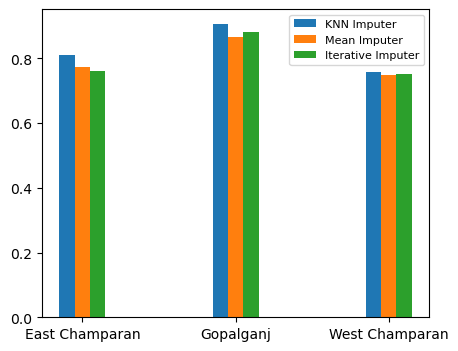

In [83]:
X_knn, y_knn, X_mean, y_mean, X_iterative, y_iterative = [], [], [], [], [], []

for method in methods:
        if method == 'knn':
            for i, data in stat_df_knn.iterrows():
                X_knn.append(i+1-0.1)
                y_knn.append(data['Test_Pearson_R'])
        elif method == 'mean':
            for i, data in stat_df_mean.iterrows():
                X_mean.append(i+1)
                y_mean.append(data['Test_Pearson_R'])
        elif method == 'iterative':
            for i, data in stat_df_iterative.iterrows():
                X_iterative.append(i+1+0.1)
                y_iterative.append(data['Test_Pearson_R'])

width=0.1
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_knn, y_knn, width, label='KNN Imputer')
plt.bar(X_mean, y_mean, width, label='Mean Imputer')
plt.bar(X_iterative, y_iterative, width, label='Iterative Imputer')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(fontsize=8)

### RT_RF

In [85]:
methods = ['knn', 'mean', 'iterative']

for method in methods:
    if method == 'knn':
        stat_df_knn = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, lat_long_split=True))
    elif method == 'mean':
        stat_df_mean = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, lat_long_split=True))
    elif method == 'iterative':
        stat_df_iterative = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, lat_long_split=True))

In [86]:
stat_df_knn

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,23.827918,0.853745,32.864525,0.716611
1,Gopalganj_data,23.389834,0.897384,41.663911,0.725153
2,West_Champaran_data,18.243787,0.880277,47.035088,0.637479


In [87]:
stat_df_mean

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,23.030919,0.845663,35.565134,0.676432
1,Gopalganj_data,21.863807,0.904876,43.609478,0.720520
2,West_Champaran_data,27.163582,0.850758,25.518391,0.626582


In [88]:
stat_df_iterative

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,20.990233,0.879535,36.809989,0.550147
1,Gopalganj_data,23.226761,0.897790,43.018946,0.749217
2,West_Champaran_data,20.182948,0.853872,43.477893,0.646383


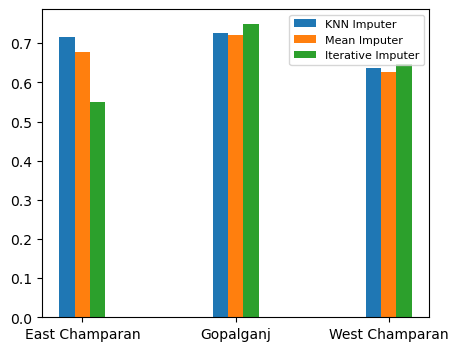

In [90]:
X_knn, y_knn, X_mean, y_mean, X_iterative, y_iterative = [], [], [], [], [], []

for method in methods:
        if method == 'knn':
            for i, data in stat_df_knn.iterrows():
                X_knn.append(i+1-0.1)
                y_knn.append(data['Test_Pearson_R'])
        elif method == 'mean':
            for i, data in stat_df_mean.iterrows():
                X_mean.append(i+1)
                y_mean.append(data['Test_Pearson_R'])
        elif method == 'iterative':
            for i, data in stat_df_iterative.iterrows():
                X_iterative.append(i+1+0.1)
                y_iterative.append(data['Test_Pearson_R'])

width=0.1
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_knn, y_knn, width, label='KNN Imputer')
plt.bar(X_mean, y_mean, width, label='Mean Imputer')
plt.bar(X_iterative, y_iterative, width, label='Iterative Imputer')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(fontsize=8)

## Comparison between Random, Latlong and Timestamp splits